# 2024 CITS4012 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

## imports

In [110]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Dataset Path




In [111]:
db_path = "dataset"

train_file = f"{db_path}/train.json"
test_file = f"{db_path}/test.json"
val_file = f"{db_path}/validation.json"

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [112]:
import json
with open(train_file, "r") as fp:
    train = json.load(fp)
with open(val_file, "r") as fp:
    val = json.load(fp)
with open(test_file, "r") as fp:
    test = json.load(fp)

train['premise']['0'], train['hypothesis']['0'], train['label']['0'], len(train['premise'])



('Pluto rotates once on its axis every 6.39 Earth days;',
 'Earth rotates on its axis once times in one day.',
 'neutral',
 23088)

In [113]:
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk import pos_tag
import numpy as np


class Config:
    stem = False
    stemmer = PorterStemmer()
    lemmatize = True
    lemmatizer = WordNetLemmatizer()
    tokenize = True

    clean_text = True
    regex = r"[^a-z0-9\-\s]"

    pos = True
    pos_tagger = pos_tag

    lower = True

    stopwords = set(stopwords.words('english'))




class textProcesser():
    def __init__(self, cfg: Config) -> None:
        self.cfg = cfg

        self.lemmatizer = cfg.lemmatizer
        self.stemmer = cfg.stemmer
        self.stop_words = cfg.stopwords

        self.pos_tagger = cfg.pos_tagger


    def clean(self, sentence: str) -> list[str]:

        clean = {
            'tokens': [],
            'pos': [],
            'segments': []
        }
        tokens = [sentence]

        if self.cfg.tokenize:
            tokens = nltk.word_tokenize(sentence)

        if self.cfg.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        if self.cfg.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]

        if self.cfg.clean_text:
            tokens = [re.sub(self.cfg.regex, '', token.lower() if self.cfg.lower else token) for token in tokens]
            tokens = [token for token in tokens if token and token not in self.stop_words]

        if self.cfg.pos:
            tokens_pos = pos_tag(tokens)
            tokens, pos_tags = zip(*tokens_pos) if tokens_pos else ([], [])
            clean['pos'] = pos_tags
            clean['tokens'] = tokens

            

        return clean
    
    def clean_text(self, json):
        clean = {
            'premise': {},
            'premise_pos': {},
            'hypothesis': {},
            'hypothesis_pos': {},
            'label': {}
        }

        for idx, key in enumerate(json['label'].keys()):
            premise_clean = self.clean(json['premise'][key])
            h_clean = self.clean(json['hypothesis'][key])

            p_tokens, p_pos = premise_clean['tokens'], premise_clean['pos']
            h_tokens, h_pos = h_clean['tokens'], h_clean['pos']

            if len(p_tokens) == 0 or len(h_tokens) == 0:
                print(f" Warning: Empty premise or hypothesis at index {idx} (key: {key}).")

            clean['label'][idx] = 0 if 'neutral' in json['label'][key] else 1
            clean['premise'][idx] = p_tokens
            clean['premise_pos'][idx] = p_pos

            if len(p_tokens) != len(p_pos):
                raise ValueError(f"Mismatch in premise tokens and POS tags at index {idx} (key: {key}). len(p_tokens): {len(p_tokens)}, len(p_pos): {len(p_pos)}")
            clean['hypothesis'][idx] = h_tokens
            clean['hypothesis_pos'][idx] = h_pos

        return clean
    

In [114]:
cfg = Config()

clean_train = textProcesser(cfg).clean_text(train)
clean_val = textProcesser(cfg).clean_text(val)
clean_test = textProcesser(cfg).clean_text(test)

In [115]:
clean_train['premise'][146], clean_train['hypothesis'][146], clean_train['label'][146], clean_train['premise_pos'][146], clean_train['hypothesis_pos'][146]


([],
 ('take', 'earth', 'one', 'week', 'rotate', 'axis', 'seven', 'time'),
 0,
 [],
 ('VB', 'NN', 'CD', 'NN', 'NN', 'VBD', 'CD', 'NN'))

In [116]:
import pandas as pd
train_df = pd.DataFrame({
    "label": clean_train["label"],
    "premise": clean_train["premise"],
    "hypothesis": clean_train["hypothesis"],
    "premise_pos": clean_train["premise_pos"],
    "hypothesis_pos": clean_train["hypothesis_pos"],
})
val_df = pd.DataFrame({
    "label": clean_val["label"],
    "premise": clean_val["premise"],
    "hypothesis": clean_val["hypothesis"],
    "premise_pos": clean_val["premise_pos"],
    "hypothesis_pos": clean_val["hypothesis_pos"],

})

test_df = pd.DataFrame({
    "label": clean_test["label"],
    "premise": clean_test["premise"],
    "hypothesis": clean_test["hypothesis"],
    "premise_pos": clean_test["premise_pos"],
    "hypothesis_pos": clean_test["hypothesis_pos"],
})

train_df = train_df.reset_index(drop=True)
train_df.iloc[0]

label                                                          0
premise           (pluto, rotates, axis, every, 639, earth, day)
hypothesis                (earth, rotates, axis, time, one, day)
premise_pos                       (NN, NNS, VBP, DT, CD, NN, NN)
hypothesis_pos                         (NN, VBZ, JJ, NN, CD, NN)
Name: 0, dtype: object

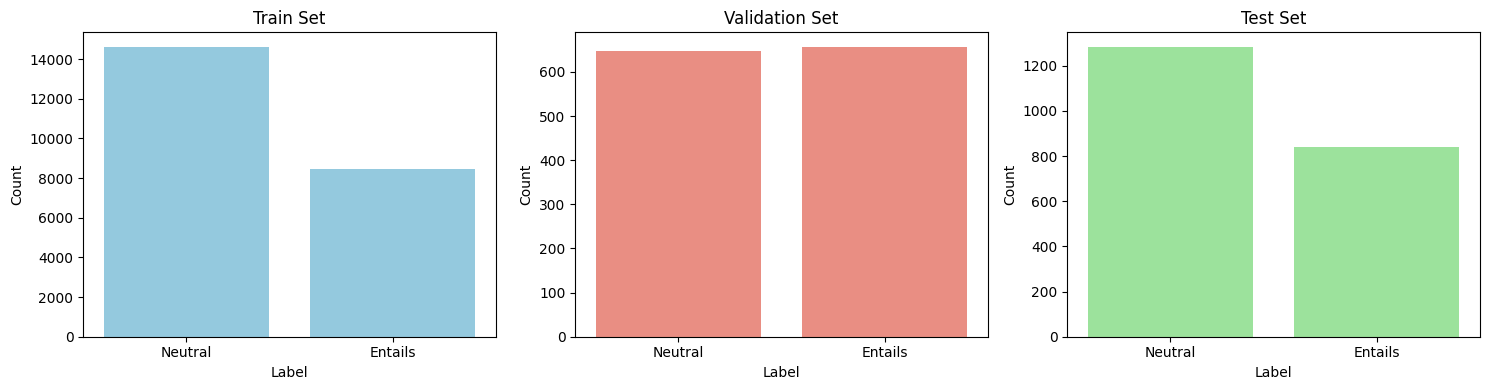

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

splits = [('Train', train_df), ('Validation', val_df), ('Test', test_df)]
colors = ['skyblue', 'salmon', 'lightgreen']  # one color per split

plt.figure(figsize=(15,4))

for i, ((name, df), color) in enumerate(zip(splits, colors), 1):
    plt.subplot(1, 3, i)
    counts = df['label'].value_counts().sort_index()
    sns.barplot(x=['Neutral', 'Entails'], y=counts.values, color=color)
    plt.title(f"{name} Set")
    plt.xlabel("Label")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [118]:
# Build pos2idx from training set only
all_pos_tags = set()
for pos_list in train_df['premise_pos']:
    all_pos_tags.update(pos_list)
for pos_list in train_df['hypothesis_pos']:
    all_pos_tags.update(pos_list)

# Add a special <UNK> token
pos2idx = {pos: i for i, pos in enumerate(sorted(all_pos_tags))}
pos2idx['<UNK>'] = len(pos2idx)
num_pos_tags = len(pos2idx)

def encode_pos(pos_list, pos2idx):
    return [pos2idx.get(pos, pos2idx['<UNK>']) for pos in pos_list]


len(pos2idx)


37

In [119]:
from gensim.models import Word2Vec
sentences = list(clean_train['premise'].values()) + list(clean_train['hypothesis'].values())
embed_model = Word2Vec(sentences=sentences, vector_size=200, window=10, min_count=3, workers=2, sg=1)

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Task

In [133]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,  DataLoader

class nliDataset(Dataset):
  def __init__(self, df, embed_model, pos_embed_model=None, pos2idx=pos2idx, encode_pos=encode_pos):
    self.df = df
    self.embed_model = embed_model
    self.pos_encode = encode_pos
    self.pos2idx = pos2idx

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    premise = self.df["premise"].iloc[index]
    hypothesis = self.df["hypothesis"].iloc[index]
    
    p_embed = np.array([
        self.embed_model.wv[word] if word in self.embed_model.wv else np.zeros(self.embed_model.vector_size)
        for word in premise
    ])
    h_embed = np.array([
        self.embed_model.wv[word] if word in self.embed_model.wv else np.zeros(self.embed_model.vector_size)
        for word in hypothesis
    ])


    if len(p_embed) == 0:
        p_embed = np.zeros((1, self.embed_model.vector_size))
    if len(h_embed) == 0:
        h_embed = np.zeros((1, self.embed_model.vector_size))
    

    premise_pos = self.df["premise_pos"].iloc[index]
    hypothesis_pos = self.df["hypothesis_pos"].iloc[index]

    premise_pos = self.pos_encode(premise_pos, self.pos2idx)
    hypothesis_pos = self.pos_encode(hypothesis_pos, self.pos2idx)

    # If embeddings were padded to length 1, also pad POS
    if len(p_embed) == 1 and len(premise) == 0:
        premise_pos = [self.pos2idx['<UNK>']]
    if len(h_embed) == 1 and len(hypothesis) == 0:
        hypothesis_pos = [self.pos2idx['<UNK>']]



  

    if len(premise_pos) != len(p_embed):
        raise ValueError(f"Mismatch in lengths at index {index}. premise_pos length: {len(premise_pos)}, p_embed length: {len(p_embed)}")


    label = int(self.df["label"].iloc[index])
    p_embed = torch.tensor(p_embed, dtype=torch.float32)
    premise_pos = torch.tensor(premise_pos, dtype=torch.long)

    h_embed = torch.tensor(h_embed, dtype=torch.float32)
    hypothesis_pos = torch.tensor(hypothesis_pos, dtype=torch.long)

    label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
    p_seg = torch.tensor(0, dtype=torch.long).unsqueeze(0)
    h_seg = torch.tensor(1, dtype=torch.long).unsqueeze(0)

    
    
    sample = {
        "p_embed": p_embed,
        "h_embed": h_embed,
        "label": label,
        "premise_pos": premise_pos,
        "hypothesis_pos": hypothesis_pos,
        "premise_segments": p_seg,
        "hypothesis_segments": h_seg,
    }

    return sample


In [121]:
db = nliDataset(train_df, embed_model)
db.__getitem__(0)

{'p_embed': tensor([[ 0.0393, -0.0446, -0.2052,  ..., -0.0653,  0.2923, -0.1767],
         [ 0.2034, -0.1662, -0.3517,  ..., -0.0573,  0.3662, -0.1239],
         [ 0.1116,  0.0587, -0.4929,  ..., -0.0066,  0.1132, -0.1983],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.3083, -0.2020, -0.4449,  ..., -0.0050,  0.3945,  0.0448],
         [ 0.1779, -0.1923, -0.5290,  ..., -0.1347,  0.2418, -0.1905]]),
 'h_embed': tensor([[ 0.3083, -0.2020, -0.4449,  ..., -0.0050,  0.3945,  0.0448],
         [ 0.2034, -0.1662, -0.3517,  ..., -0.0573,  0.3662, -0.1239],
         [ 0.1116,  0.0587, -0.4929,  ..., -0.0066,  0.1132, -0.1983],
         [ 0.2147,  0.2590, -0.1726,  ...,  0.0369,  0.0336, -0.1702],
         [-0.4303,  0.1614, -0.0604,  ...,  0.0351, -0.0720,  0.1962],
         [ 0.1779, -0.1923, -0.5290,  ..., -0.1347,  0.2418, -0.1905]]),
 'label': tensor([0.]),
 'premise_pos': tensor([13, 15, 30,  5,  4, 13, 13]),
 'hypothesis_pos': tensor([13,

In [134]:
import torch
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    p_embeds = [item["p_embed"] for item in batch]
    h_embeds = [item["h_embed"] for item in batch]
    p_pos_idx = [item["premise_pos"] for item in batch]
    h_pos_idx = [item["hypothesis_pos"] for item in batch]

    p_segments = [item["premise_segments"] for item in batch]
    h_segments = [item["hypothesis_segments"] for item in batch]
    labels = [item["label"] for item in batch]


    p_padded = pad_sequence(p_embeds, batch_first=True) 
    h_padded = pad_sequence(h_embeds, batch_first=True) 
    p_pos_padded = pad_sequence(p_pos_idx, batch_first=True, padding_value=pos2idx['<UNK>'])
    h_pos_padded = pad_sequence(h_pos_idx, batch_first=True, padding_value=pos2idx['<UNK>'])

    labels = torch.stack(labels)

    p_seg = torch.stack(p_segments)
    h_seg = torch.stack(h_segments)

    plengths = torch.tensor([x.shape[0] for x in p_embeds])
    hlengths = torch.tensor([x.shape[0] for x in h_embeds])


    if p_pos_padded.shape[1] != p_padded.shape[1]:
        raise ValueError("Mismatch in padded lengths between p_pos and p_embed.")
    return {
        "p_embed": p_padded,
        "h_embed": h_padded,
        "p_pos": p_pos_padded,
        "h_pos": h_pos_padded,
        "label": labels,
        "p_lengths": plengths,
        "h_lengths": hlengths,
        "p_segments": p_seg,
        "h_segments": h_seg
    }



train_db = nliDataset(train_df, embed_model=embed_model)
trainloader = DataLoader(train_db, batch_size=8, shuffle=False, collate_fn=collate_fn)
val_db = nliDataset(val_df, embed_model=embed_model)
valloader = DataLoader(val_db, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_db = nliDataset(test_df, embed_model=embed_model)
testloader = DataLoader(test_db, batch_size=8, shuffle=False, collate_fn=collate_fn)

len(trainloader), len(valloader), len(testloader)

(2886, 163, 266)

In [123]:
out = next(iter(trainloader))
for key, value in out.items():
    print(f"{key}: {value}")

p_embed: tensor([[[ 0.0393, -0.0446, -0.2052,  ..., -0.0653,  0.2923, -0.1767],
         [ 0.2034, -0.1662, -0.3517,  ..., -0.0573,  0.3662, -0.1239],
         [ 0.1116,  0.0587, -0.4929,  ..., -0.0066,  0.1132, -0.1983],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0356, -0.3345, -0.1316,  ...,  0.0499,  0.0370, -0.3361],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.5305, -0.0482, -0.2284,  ..., -0.3207, -0.4024, -0.3470],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1904,  0.0721, -0.1574,  ..., -0.3276, -0.0345, -0.0793],
         [-0.0847, -0.2717, -0.0088,

In [176]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

class Task():
  def __init__(self, model, 
                train_df, 
                val_df, 
                save_path, 
                collate_fn=collate_fn, 
                optimizer=None,
                loss_fn=None,
                device="cpu", 
                batch_size=16, 
                weighted_sampling=False,
                forward_func=None) -> None:

    self.train_df = train_df
    self.val_df = val_df

    self.optimizer = optimizer
    self.loss_fn = loss_fn

    self.forward = forward_func if forward_func is not None else model.forward

    self.save_path = save_path

    if weighted_sampling:
      labels = train_df['label'].values
      class_counts = Counter(labels)
      num_samples = len(labels)
      class_weights = {cls: num_samples/count for cls, count in class_counts.items()}
      sample_weights = [class_weights[label] for label in labels]
      sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
    else:
      sampler = None
    
    train_db = nliDataset(train_df, embed_model=embed_model)
    val_db = nliDataset(val_df, embed_model=embed_model)

    self.train_loader = DataLoader(train_db, batch_size=batch_size, sampler=sampler, shuffle=True, collate_fn=collate_fn)
    self.val_loader = DataLoader(val_db, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    self.model = model
    self.device = device


    self.model = model.to(device)

    self.losses = {}
    self.losses["train"] = []
    self.losses["val"] = []

  def train_epoch(self):
    self.model.train()
    epoch_loss = 0
    for batch in tqdm(self.train_loader, total=len(self.train_loader), desc="Training"):
        
        labels = batch["label"]
        labels = labels.to(self.device)

        outputs = self.forward(batch, self.model, self.device)
        loss = self.loss_fn(outputs, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(self.train_loader)
    return epoch_loss
  

  def validate_epoch(self):
    self.model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(self.val_loader, total=len(self.val_loader), desc="Validating"):
            
          labels = batch["label"]
          labels = labels.to(self.device)

          outputs = self.forward(batch, self.model, self.device)
          loss = self.loss_fn(outputs, labels)
          val_loss += loss.item()


          predicted = (torch.sigmoid(outputs) > 0.5).long().squeeze()  # shape [batch_size]
          correct += (predicted == labels.squeeze()).sum().item()

          total += labels.size(0)

        val_loss /= len(self.val_loader)
        accuracy = correct / total
    return val_loss, accuracy
     

  def fit(self, epochs=10, restore_best=True, patience=3):
    count = 0
    best_val_loss = float('inf')
    for epoch in range(epochs):
        train_loss = self.train_epoch()
        val_loss, val_acc = self.validate_epoch()

        self.losses["train"].append(train_loss)
        self.losses["val"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            count = 0
            torch.save(self.model.state_dict(), self.save_path)
            print(f"Model saved to {self.save_path}")

        count += 1
        if count >= patience:
            print(f"No improvement in validation loss for {patience} consecutive epochs. Early stopping.")
            break

    print("Training complete.")
    if restore_best:
      print("Restoring best model weights.")
      self.model.load_state_dict(torch.load(self.save_path))
    return self.losses
  

  def plot_losses(self):
    plt.figure(figsize=(10,5))
    plt.plot(self.losses["train"], label="Train Loss")
    plt.plot(self.losses["val"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.show()


  def visualize_predictions(self, num_samples=5):
    """
    Visualizes predictions vs targets for a few random samples from the validation set.

    Args:
        task: Your Task object (with .model and .val_loader)
        num_samples: Number of random examples to show
    """
    self.model.eval()
    all_samples = []

    # Collect a few batches
    with torch.no_grad():
        for batch in self.val_loader:
            labels = batch["label"].to(self.device)
            outputs = self.forward(batch, self.model, self.device)
            probs = torch.sigmoid(outputs.squeeze())

            for prob, label in zip(probs, labels):
                pred_label = int(prob > 0.5)
                all_samples.append((prob.item(), pred_label, int(label.item())))

    samples_to_show = random.sample(all_samples, min(num_samples, len(all_samples)))

    print(f"{'Pred Prob':>10} | {'Pred Label':>10} | {'Target':>6}")
    print("-"*32)
    for prob, pred, target in samples_to_show:
        print(f"{prob:10.3f} | {pred:10} | {target:6}")

  def evaluate(self):
        """
        Evaluate the model on the validation set and return classification metrics.
        Returns:
            dict: Contains accuracy, precision, recall, f1, confusion matrix, and full report
        """
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, total=len(self.val_loader), desc="Evaluating"):
                outputs = self.forward(batch, self.model, self.device)
                probs = torch.sigmoid(outputs.squeeze())
                preds = (probs > 0.5).long()

                all_preds.extend(preds.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())

        # Compute metrics
        metrics = {
            "accuracy": accuracy_score(all_labels, all_preds),
            "precision": precision_score(all_labels, all_preds, zero_division=0),
            "recall": recall_score(all_labels, all_preds, zero_division=0),
            "f1": f1_score(all_labels, all_preds, zero_division=0),
            "confusion_matrix": confusion_matrix(all_labels, all_preds).tolist(),
            "classification_report": classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
        }

        return metrics
  

  def visualize_metrcis(self, metrics_dict, class_names=['Neutral', 'Entails']):
      """
      Visualize metrics, confusion matrix, and classification report from a precomputed metrics dictionary.

      Args:
          metrics_dict (dict): Dictionary containing 'accuracy', 'precision', 'recall', 'f1',
                              'confusion_matrix' (as list of lists), and 'classification_report' (as dict)
          class_names (list, optional): Class names for confusion matrix
      """

      # 1. Display main metrics
      print("=== Overall Metrics ===")
      for key in ["accuracy", "precision", "recall", "f1"]:
          print(f"{key.capitalize():<10}: {metrics_dict[key]:.4f}")
      print("\n")

      # 2. Confusion Matrix
      cm = metrics_dict["confusion_matrix"]
      plt.figure(figsize=(6, 5))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=class_names, yticklabels=class_names)
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.title('Confusion Matrix')
      plt.show()

      # 3. Classification Report
      report_dict = metrics_dict["classification_report"]
      report_df = pd.DataFrame(report_dict).transpose()
      print("=== Classification Report ===\n")
      display(report_df)  # nicer tabular display in notebooks

      # Optional: bar plot for main metrics
      plt.figure(figsize=(5, 4))
      main_metrics = ["accuracy", "precision", "recall", "f1"]
      values = [metrics_dict[m] for m in main_metrics]
      sns.barplot(x=main_metrics, y=values, palette="viridis")
      plt.ylim(0, 1)
      plt.title("Main Metrics")
      plt.show()


## BiLSTM

In [177]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class twin_LSTM(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, output_size=1, 
                 dropout=0.5, bidirectional=True, n_layers=3,
                 pos_vocab_size=None, pos_emb_dim=16):
        super().__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Word + POS embeddings combined
        self.pos_embedding = nn.Embedding(pos_vocab_size, pos_emb_dim) if pos_vocab_size else None
        combined_input_size = input_size + (pos_emb_dim if pos_vocab_size else 0)

        self.px_lstm = nn.LSTM(combined_input_size, self.hidden_size, 
                               num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
        self.hx_lstm = nn.LSTM(combined_input_size, self.hidden_size, 
                               num_layers=n_layers, bidirectional=bidirectional, batch_first=True)

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size * 2 * (2 if bidirectional else 1), output_size),
        )

    def forward(self, px, hx, plengths=None, hlengths=None, p_pos_idx=None, h_pos_idx=None):
        # Add POS embeddings if provided
        if self.pos_embedding is not None and p_pos_idx is not None and h_pos_idx is not None:
            p_pos_emb = self.pos_embedding(p_pos_idx)
            h_pos_emb = self.pos_embedding(h_pos_idx)


            px = torch.cat([px, p_pos_emb], dim=2)
            hx = torch.cat([hx, h_pos_emb], dim=2)

        # Pack sequences
        packed_px = pack_padded_sequence(px, plengths.cpu(), batch_first=True, enforce_sorted=False)
        px_output, (px_hn, _) = self.px_lstm(packed_px)

        packed_hx = pack_padded_sequence(hx, hlengths.cpu(), batch_first=True, enforce_sorted=False)
        hx_output, (hx_hn, _) = self.hx_lstm(packed_hx)

        # Take last hidden state(s)

        if self.bidirectional:
            px_out = torch.cat([px_hn[-2], px_hn[-1]], dim=1)
            hx_out = torch.cat([hx_hn[-2], hx_hn[-1]], dim=1)
        else:
            px_out = px_hn[-1]
            hx_out = hx_hn[-1]

        out = self.fc(torch.cat([px_out, hx_out], dim=1))
        return out


In [ ]:

pos_vocab_size = len(pos2idx) 
pos_emb_dim = 32              

model = twin_LSTM(
    input_size=embed_model.vector_size,
    hidden_size=128,
    output_size=1,
    dropout=0.5,
    bidirectional=True,
    n_layers=2,
    pos_vocab_size=0,
    pos_emb_dim=pos_emb_dim
)

def twin_forward(batch, model, device):
    p_embed = batch["p_embed"].to(device)
    h_embed = batch["h_embed"].to(device)

    p_lengths = batch["p_lengths"]
    h_lengths = batch["h_lengths"]
    premise_pos = batch["p_pos"]
    hypothesis_pos = batch["h_pos"]

    outputs = model(p_embed, h_embed, p_lengths, h_lengths, premise_pos, hypothesis_pos)
    return outputs


twin_task = Task(
    model=model,
    train_df=train_df,
    val_df=val_df,
    save_path="whatever.pth",
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    loss_fn=nn.BCEWithLogitsLoss(),
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=8    ,
    weighted_sampling=False,
    forward_func=twin_forward
)



In [ ]:
twin_task.fit(epochs=20)

Training:  45%|████▍     | 1285/2886 [01:14<01:32, 17.32it/s]


KeyboardInterrupt: 

## Bert Inspired Model

The BERT model from Devlin et al's 2018 paper implements a summation embedding of token, segment and position.

In [ ]:
def batch_truncate(premises, hypotheses, max_len):
    """
    Randomly truncate each premise/hypothesis pair in the batch to fit max_len.
    
    premises: list of tensors [(p_len_i, dim), ...] or tensor (b, p_len, dim)
    hypotheses: list of tensors [(h_len_i, dim), ...] or tensor (b, h_len, dim)
    Returns:
        truncated_premises, truncated_hypotheses: lists of tensors
    """
    truncated_premises = []
    truncated_hypotheses = []

    for p, h in zip(premises, hypotheses):
        p_len, h_len = p.size(0), h.size(0)
        total_len = p_len + h_len

        while total_len > max_len:
            if p_len > h_len and p_len > 1:
                if random.random() < 0.5:
                    p = p[1:]
                else:
                    p = p[:-1]
                p_len -= 1
            elif h_len > 1:
                if random.random() < 0.5:
                    h = h[1:]
                else:
                    h = h[:-1]
                h_len -= 1
            elif p_len > 1:
                if random.random() < 0.5:
                    p = p[1:]
                else:
                    p = p[:-1]
                p_len -= 1
            total_len = p_len + h_len

        truncated_premises.append(p)
        truncated_hypotheses.append(h)

    return truncated_premises, truncated_hypotheses


def batch_pad(truncated_premises, truncated_hypotheses, max_len, premise_seg_id=1, hypothesis_seg_id=2, pad_value=0.0):
    """
    Pad each truncated sequence to max_len and create segments and attention masks.
    Returns:
        padded_seqs: (b, max_len, dim)
        segments: (b, max_len)
        attn_masks: (b, max_len)
    """
    embed_dim = truncated_premises[0].size(1)

    padded_seqs = []
    segments_batch = []
    attn_masks_batch = []

    for p, h in zip(truncated_premises, truncated_hypotheses):
        p_len, h_len = p.size(0), h.size(0)
        seq = torch.cat([p, h], dim=0)
        pad_len = max_len - seq.size(0)
        if pad_len > 0:
            seq = torch.cat([seq, torch.full((pad_len, embed_dim), pad_value)], dim=0)

        segments = torch.cat([
            torch.full((p_len,), premise_seg_id, dtype=torch.long),
            torch.full((h_len,), hypothesis_seg_id, dtype=torch.long),
            torch.full((pad_len,), 0, dtype=torch.long)
        ])

        attn_mask = torch.cat([
            torch.ones(p_len + h_len, dtype=torch.long),
            torch.zeros(pad_len, dtype=torch.long)
        ])

        padded_seqs.append(seq)
        segments_batch.append(segments)
        attn_masks_batch.append(attn_mask)

    padded_seqs = torch.stack(padded_seqs)
    segments_batch = torch.stack(segments_batch)
    attn_masks_batch = torch.stack(attn_masks_batch)

    return padded_seqs, segments_batch, attn_masks_batch


In [ ]:
batch = next(iter(trainloader))
premises = batch['p_embed']
hypotheses = batch['h_embed']
# Step 1: Truncate
truncated_premises, truncated_hypotheses = batch_truncate(premises, hypotheses, max_len=20)

# Step 2: Pad
padded_seqs, segments, attn_masks = batch_pad(truncated_premises, truncated_hypotheses, max_len=20)

print(padded_seqs.shape, segments.shape, attn_masks.shape)


torch.Size([8, 20, 200]) torch.Size([8, 20]) torch.Size([8, 20])


In [193]:
import torch
import torch.nn as nn

class BERTEmbedding(nn.Module):
    def __init__(self,
                 n_segments,
                 max_len,
                 embed_dim,
                 dropout):
        super().__init__()
        self.seg_embed = nn.Embedding(n_segments, embed_dim)
        self.pos_embed = nn.Embedding(max_len, embed_dim)

        self.drop = nn.Dropout(dropout)

    def forward(self, x, seg):


        seg_embed = self.seg_embed(seg)

        batch_size, seq_len, _ = x.size()
        pos_ids = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)  # (batch, seq_len)
        pos_embed = self.pos_embed(pos_ids)  

        embed_val = x + seg_embed + pos_embed
        embed_val = self.drop(embed_val)
        return embed_val


class BERT(nn.Module):
    def __init__(self,
                 n_segments,
                 max_len,
                 embed_dim,
                 n_layers,
                 attn_heads,
                 dropout):
        super().__init__()
        self.embedding = BERTEmbedding(n_segments, max_len, embed_dim, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(embed_dim, attn_heads, embed_dim*4, batch_first=True)
        self.encoder_block = nn.TransformerEncoder(self.encoder_layer, n_layers)

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 32)
            , nn.ReLU()
            , nn.Dropout(dropout)
            , nn.Linear(32, 1)

        )



    def forward(self, x, seq, attention_mask=None):
        x = self.embedding(x, seg)

        if attention_mask is not None:
            # TransformerEncoder expects mask of shape (batch_size, seq_len) -> key_padding_mask
            # True means **ignore** (mask out), False means attend
            key_padding_mask = attention_mask == 0
        else:
            key_padding_mask = None

        out = self.encoder_block(x, src_key_padding_mask=key_padding_mask)
        pooled = (out * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

        logits = self.fc(pooled)
        return logits


if __name__ == "__main__":
    N_SEGMENTS = 3
    MAX_LEN = 128
    EMBED_DIM = 200
    N_LAYERS = 12
    ATTN_HEADS = 10
    DROPOUT = 0.1

    batch = next(iter(trainloader))

    premise = batch["p_embed"]
    hypothesis = batch["h_embed"]
    p_seg = batch["p_segments"]
    h_seg = batch["h_segments"]


    p, h = batch_truncate(premise, hypothesis, max_len=MAX_LEN)
    x, seg, attn_mask = batch_pad(p, h, max_len=MAX_LEN)
    
    print(x.size(), seg.size(), attn_mask.size())

    embedding = BERT(
        n_segments=N_SEGMENTS,
        max_len=MAX_LEN,
        embed_dim=EMBED_DIM,
        n_layers=N_LAYERS,
        attn_heads=ATTN_HEADS,
        dropout=DROPOUT
    )
    embedding.eval()
    out = embedding(x, seg, attn_mask)

    print(out.size())

torch.Size([8, 128, 200]) torch.Size([8, 128]) torch.Size([8, 128])
torch.Size([8, 1])


In [194]:
bert_model = BERT(
    n_segments=3,
    max_len=128,
    embed_dim=embed_model.vector_size,
    n_layers=4,
    attn_heads=8,
    dropout=0.1
)
def bert_forward(batch, model, device):
    premise = batch["p_embed"].to(device)
    hypothesis = batch["h_embed"].to(device)

    p, h = batch_truncate(premise, hypothesis, max_len=128)
    x, seg, attn_mask = batch_pad(p, h, max_len=128)

    x = x.to(device)
    seg = seg.to(device)
    attn_mask = attn_mask.to(device)

    outputs = model(x, seg, attn_mask)
    return outputs


bert_task = Task(
    model=bert_model,
    train_df=train_df,
    val_df=val_df,
    save_path="bert_nli.pth",
    optimizer=torch.optim.Adam(bert_model.parameters(), lr=0.001),
    loss_fn=nn.BCEWithLogitsLoss(),
    device="cuda" if torch.cuda.is_available() else "cpu",
    batch_size=8,
    weighted_sampling=False,
    forward_func=bert_forward
)

In [ ]:
bert_task.fit(epochs=10)

Training:   6%|▌         | 163/2886 [00:40<11:20,  4.00it/s]

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
metrics = task.evaluate()
task.visualize_metrcis(metrics)

Evaluating: 100%|██████████| 163/163 [00:01<00:00, 85.47it/s]


=== Overall Metrics ===
Accuracy  : 0.6457
Precision : 0.6555
Recall    : 0.6256
F1        : 0.6402




NameError: name 'class_names' is not defined

<Figure size 600x500 with 0 Axes>

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*